# ここでやること
pomegranateを使って簡単なベイジアンネットワークを構成して、推論をしてみる。

## 今回作るネットワーク
外的要因（大気汚染、パンデミック）が肺がんの有無に影響を与え、肺がんかどうかが検査薬の結果に影響を与えるというベイジアンネットワークを考える。
構造としては以下の通り。

* ノード
    * 空気環境（Crearn or bad）
    * パンデミックが起こっているかどうか（Yes or No）
    * 肺がんかどうか（Yes or No）
    * 検査薬の結果(陽性 or 陰性)
    
* エッジ
    * 空気環境 → 肺がん
    * パンデミック → 肺がん
    * 肺がん → 検査薬
    
## 推論
初期に与えた確率分布の元、それぞれのノードの確率分布がどのように変化するかをみる。
その後、あるノードの値を設定した場合（例えば「検査薬が陽性」など）の各ノードの変化をみる。

In [1]:
from pomegranate import *

In [2]:
# 外部環境的な確率変数

# 大気の状態
atmosphere = DiscreteDistribution( { 'Clearn': 4./5, 'Bad': 1./5} )

# パンデミックが起こっているかどうか
pandemic = DiscreteDistribution( { 'Yes': 1./10, 'No': 9./10 } )

# 肺がんかどうか
#     肺がんの確率は大気の状態とパンデミックかどうかに依存している。
#     以下はP(肺がん | 大気, パンデミック) で表される確率を設定している。
#     例えば、P(肺がん = 'Yes' | 大気 = 'Clearn', パンデミック = 'No') の場合の確率値は0.2となる。
lung_cancer = ConditionalProbabilityTable(
        [['Clearn', 'No', 'Yes', 0.2],
         ['Clearn', 'No', 'No', 0.8],
         ['Clearn', 'Yes', 'Yes', 0.6],
         ['Clearn', 'Yes', 'No', 0.4],
         ['Bad', 'No', 'Yes', 0.6],
         ['Bad', 'No', 'No', 0.4],
         ['Bad', 'Yes', 'Yes', 0.9],
         ['Bad', 'Yes', 'No', 0.1]], [atmosphere, pandemic] )

# 検査薬が陽性か陰性か
#     検査薬の確率は肺がんかどうかに依存している。
#     以下はP(検査薬 | 肺がん) で表される確率を設定している。
#     例えば、P(検査薬 = 'Positive' | 肺がん = 'Yes') の場合の確率値は0.8となる。
test_reagent = ConditionalProbabilityTable(
         [['Yes', 'Positive', 0.8],
          ['Yes', 'Negative', 0.2],
          ['No', 'Positive', 0.2],
          ['No', 'Negative', 0.8]], [lung_cancer] )


# ベイジアンネットワークを初期化
model = BayesianNetwork( "Test Lung Cancer" )

# ノードを生成
s1 = Node( atmosphere, name="atmosphere" )
s2 = Node( pandemic, name="pandemic" )
s3 = Node( lung_cancer, name="lung_cancer" )
s4 = Node( test_reagent, name="test_reagent" )

# 4つのノードをモデルに追加
model.add_nodes(s1, s2, s3, s4)

# ノード間にエッジを張る
model.add_edge(s1, s3)
model.add_edge(s2, s3)
model.add_edge(s3, s4)
model.bake()

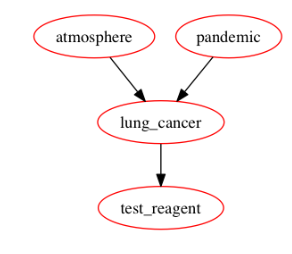

In [3]:
# モデルを描画してみる
%matplotlib inline

model.plot()

In [4]:
# それぞれのノードの確率分布が以下のようになる時、ベイジアンネットワークの状態の確率を計算

# 大気の状態 ['Clearn', 'Bad']
# パンデミックが起こっているかどうか ['Yes', 'No']
# 肺がんかどうか ['Yes', 'No']
# 検査薬が陽性か陰性か ['Positive', 'Negative']

state_1 = """
大気の状態きれい、パンデミックなし、肺がんではない、検査薬は陰性
"""
print(state_1, model.probability(['Clearn', 'No', 'No', 'Negative']))

state_2 = """
大気の状態綺麗、パンデミックなし、肺がん、検査薬は陽性
"""
print(state_2, model.probability(['Bad', 'No', 'Yes', 'Positive']))


大気の状態きれい、パンデミックなし、肺がんではない、検査薬は陰性
 [ 0.4608]

大気の状態綺麗、パンデミックなし、肺がん、検査薬は陽性
 [ 0.0864]


In [5]:
# それぞれのノードの確率を計算する
# pomegranateは推論に loopy belief propogationアルゴリズム（近似アルゴリズム）を使っている

# 引数が空（{}）の時は全てのノードの初期状態
default_model = model.predict_proba({})

print('大気状態の確率分布', default_model[0].parameters[0])
print('パンデミックの確率分布', default_model[1].parameters[0])
print('肺がんの確率分布', default_model[2].parameters[0]) # Yesが100%
print('検査薬の確率分布', default_model[3].parameters[0])

大気状態の確率分布 {'Bad': 0.20000000000000026, 'Clearn': 0.79999999999999982}
パンデミックの確率分布 {'No': 0.89999999999999958, 'Yes': 0.10000000000000035}
肺がんの確率分布 {'No': 0.68199999999999972, 'Yes': 0.31800000000000034}
検査薬の確率分布 {'Negative': 0.60919999999999974, 'Positive': 0.3908000000000002}


In [6]:
# 他の値を変えた時にどんな感じになるか予測する
# 肺がんである時の全ノードの確率
lung_cancer_yes_model = model.predict_proba({"lung_cancer": "Yes"})

print('大気状態の確率分布', lung_cancer_yes_model[0].parameters[0])
print('パンデミックの確率分布', lung_cancer_yes_model[1].parameters[0])
print('肺がんの確率分布', lung_cancer_yes_model[2].parameters[0]) # Yesが100%
print('検査薬の確率分布', lung_cancer_yes_model[3].parameters[0])

大気状態の確率分布 {'Bad': 0.39622641509433981, 'Clearn': 0.60377358490566024}
パンデミックの確率分布 {'No': 0.79245283018867863, 'Yes': 0.20754716981132135}
肺がんの確率分布 {'No': 0.0, 'Yes': 1.0}
検査薬の確率分布 {'Negative': 0.20000000000000015, 'Positive': 0.79999999999999993}


In [7]:
# 大気汚染、かつ検査薬陽性である時の全ノードの確率
atmosphere_Bad_test_reagent_Positive_model = model.predict_proba({"atmosphere": "Bad", "test_reagent": "Positive"})
print('大気状態の確率分布', atmosphere_Bad_test_reagent_Positive_model[0].parameters[0]) # Badが100%
print('パンデミックの確率分布', atmosphere_Bad_test_reagent_Positive_model[1].parameters[0])
print('肺がんの確率分布', atmosphere_Bad_test_reagent_Positive_model[2].parameters[0]) 
print('検査薬の確率分布', atmosphere_Bad_test_reagent_Positive_model[3].parameters[0]) # Positiveが100%

大気状態の確率分布 {'Bad': 1.0, 'Clearn': 0.0}
パンデミックの確率分布 {'No': 0.87197231833909994, 'Yes': 0.12802768166090009}
肺がんの確率分布 {'No': 0.12802768166089978, 'Yes': 0.87197231833910016}
検査薬の確率分布 {'Negative': 0.0, 'Positive': 1.0}


## おまけ：確率テーブルを作る
確率テーブル作るのは大変なので、その辺を確率値だけの設定でいけるようにする

In [8]:
import itertools

# 病気の状態を記述するための確率テーブルを作る
atmosphere_parameters = list(atmosphere.parameters[0].keys())
pandemic_parameters = list(pandemic.parameters[0].keys())
lung_cancer_parameters = ['Yes', 'No']

cartesian_product_1 = itertools.product(atmosphere_parameters, pandemic_parameters, lung_cancer_parameters)

# 確率値を設定
prob_vals = [0.2, 0.8, 0.6, 0.4, 0.6, 0.4, 0.9, 0.1]
probability_table = [list(state) + [prob_val]  for state, prob_val in zip(cartesian_product_1, prob_vals)]

# 検査薬の状態を記述するための確率テーブルを作る
lung_cancer_parameters = ['Yes', 'No']
test_reagent_parameters = ['Positive', 'Negative']

cartesian_product_2 = itertools.product(lung_cancer_parameters, test_reagent_parameters)

# 確率値を設定
prob_vals = [0.8, 0.2, 0.2, 0.8]

probability_table_2 = [list(state) + [prob_val]  for state, prob_val in zip(cartesian_product_2, prob_vals)]

# 中身を確認
probability_table, probability_table_2

([['Bad', 'No', 'Yes', 0.2],
  ['Bad', 'No', 'No', 0.8],
  ['Bad', 'Yes', 'Yes', 0.6],
  ['Bad', 'Yes', 'No', 0.4],
  ['Clearn', 'No', 'Yes', 0.6],
  ['Clearn', 'No', 'No', 0.4],
  ['Clearn', 'Yes', 'Yes', 0.9],
  ['Clearn', 'Yes', 'No', 0.1]],
 [['Yes', 'Positive', 0.8],
  ['Yes', 'Negative', 0.2],
  ['No', 'Positive', 0.2],
  ['No', 'Negative', 0.8]])